<a href="https://colab.research.google.com/github/ishakaran808/Time-series-analysis/blob/main/Electricity_Consumption_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
df=pd.read_csv('Electric_Production.csv')


In [37]:
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [38]:
df.columns=["Date","Value"]
df.head()

,Date,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [40]:
df['Date']=pd.to_datetime(df['Date'])
df.head()


,Date,Value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [42]:
df.set_index('Date',inplace=True)
df.head()

,Value
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [43]:
df.describe()


,Value
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


<Axes: xlabel='Date'>

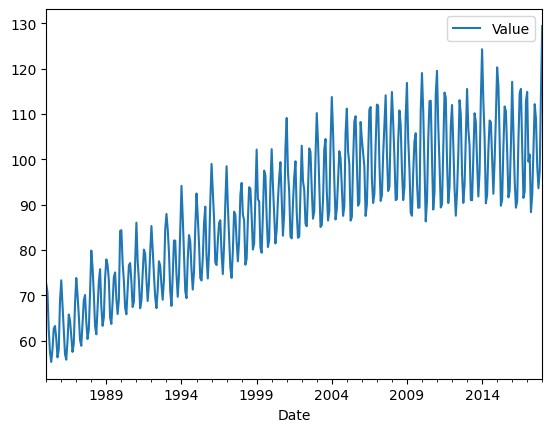

In [44]:
df.plot()

In [46]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Value'])

In [47]:
def adfuller_test(value):
    result=adfuller(value)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [49]:
adfuller_test(df['Value'])

ADF Test Statistic : -2.256990350047235
p-value : 0.1862146911658712
#Lags Used : 15
Number of Observations Used : 381
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [52]:
df['Seasonal First Difference']=df['Value']-df['Value'].shift(12)
df.head(14)


,Value,Seasonal First Difference
Date,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,NaN
1985-03-01,62.4502,NaN
1985-04-01,57.4714,NaN
1985-05-01,55.3151,NaN
1985-06-01,58.0904,NaN
1985-07-01,62.6202,NaN
1985-08-01,63.2485,NaN
1985-09-01,60.5846,NaN


In [53]:
adfuller_test(df['Seasonal First Difference'].dropna())


ADF Test Statistic : -5.673482023381762
p-value : 8.812644938088861e-07
#Lags Used : 12
Number of Observations Used : 372
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

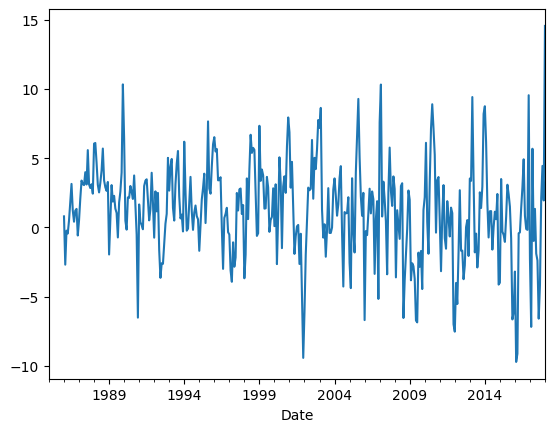

In [54]:
df['Seasonal First Difference'].plot()

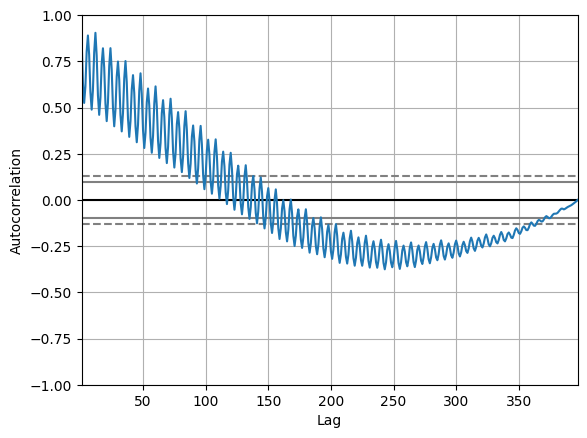

In [56]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Value'])
plt.show()

In [57]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

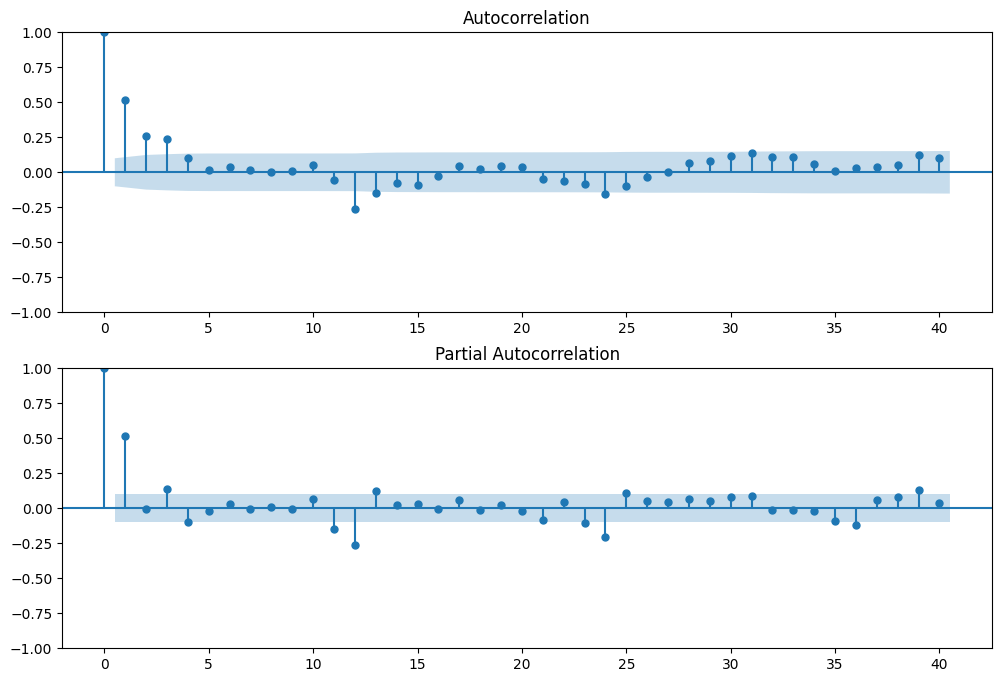

In [59]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

p=2 q=1, d=1


In [88]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Value'], order=(2, 1, 1))
model_fit = model.fit()

In [89]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  397
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1121.035
Date:                Mon, 19 Aug 2024   AIC                           2250.070
Time:                        17:39:12   BIC                           2265.995
Sample:                    01-01-1985   HQIC                          2256.379
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9171      0.033     27.935      0.000       0.853       0.981
ar.L2         -0.8324      0.025    -33.642      0.000      -0.881      -0.784
ma.L1         -0.8562      0.027    -31.149      0.000      -0.910      -0.802
sigma2        16.6907      0.965     17.288      0.000      14.798      18.583
===================================================================================
Ljung-Box (L1) (Q):                  14.65   Jarque-Bera (JB):                21.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

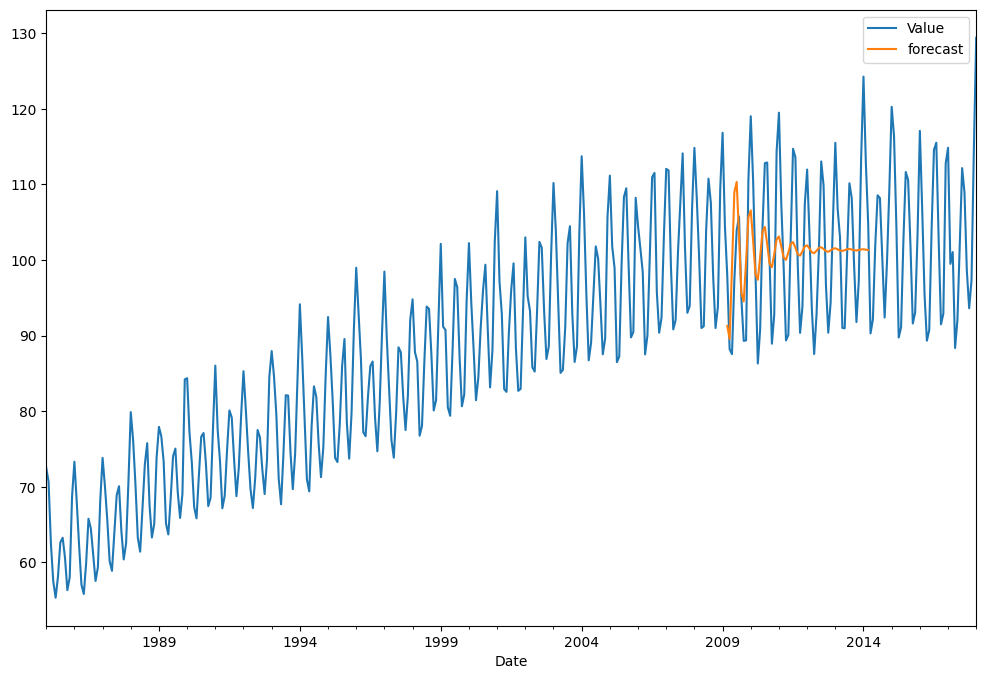

In [90]:
df['forecast']=model_fit.predict(start=290,end=350,dynamic=True)
df[['Value','forecast']].plot(figsize=(12,8))

In [91]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Value'],order=(2, 1, 1),seasonal_order=(2,1,1,12))
results=model.fit()

<Axes: xlabel='Date'>

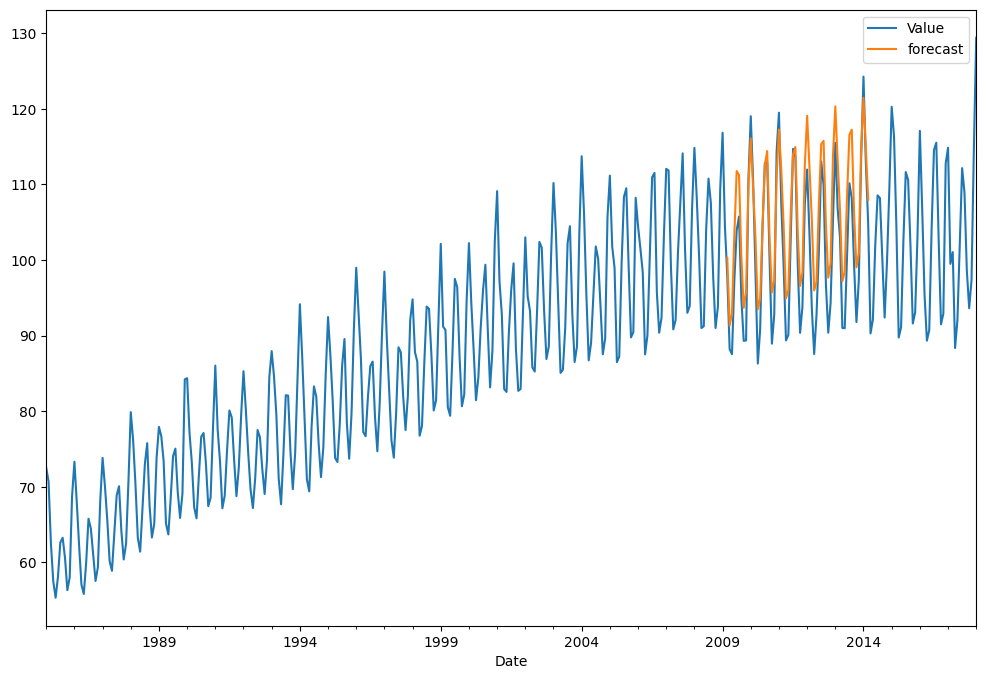

In [92]:
df['forecast']=results.predict(start=290,end=350,dynamic=True)
df[['Value','forecast']].plot(figsize=(12,8))

In [72]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [73]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)


In [74]:
future_datest_df.tail()

,Value,Seasonal First Difference,forecast
2019-08-01,NaN,NaN,NaN
2019-09-01,NaN,NaN,NaN
2019-10-01,NaN,NaN,NaN
2019-11-01,NaN,NaN,NaN
2019-12-01,NaN,NaN,NaN


In [75]:
future_df=pd.concat([df,future_datest_df])

<Axes: >

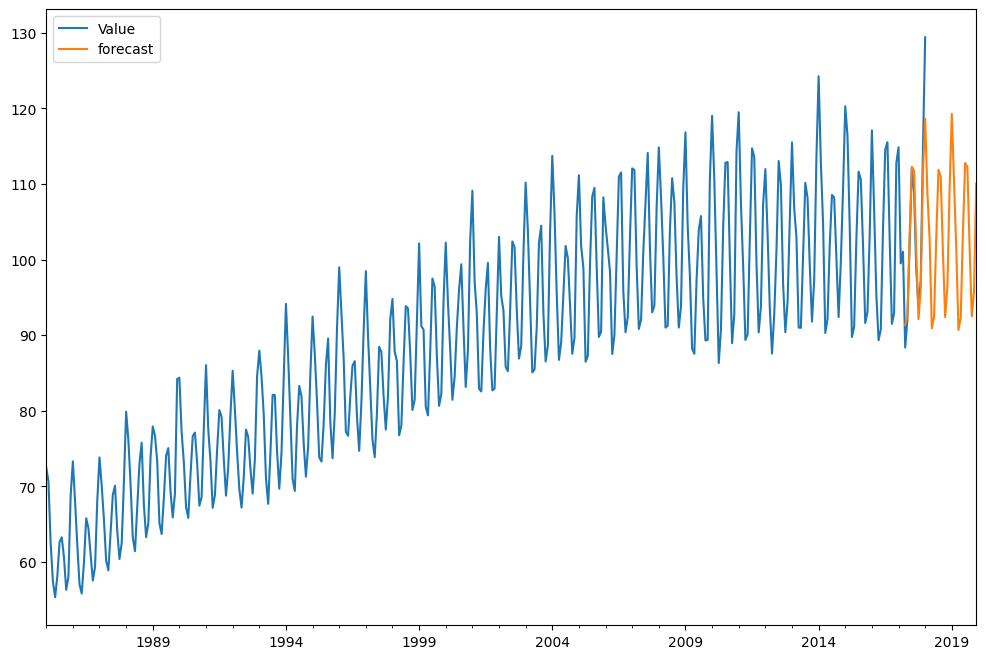

In [79]:
future_df['forecast'] = results.predict(start = 387, end = 420, dynamic= True)
future_df[['Value', 'forecast']].plot(figsize=(12, 8))

In [94]:
print(f"Number of NaNs in actual values: {actual.isna().sum()}")
print(f"Number of NaNs in forecast values: {forecast.isna().sum()}")

actual = actual.dropna()
forecast = forecast.dropna()

min_length = min(len(actual), len(forecast))
actual = actual[:min_length]
forecast = forecast[:min_length]

Number of NaNs in actual values: 23
Number of NaNs in forecast values: 0


In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, forecast)

rmse = np.sqrt(mean_squared_error(actual, forecast))

mape = np.mean(np.abs((actual - forecast) / actual)) * 100

smape = np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"sMAPE: {smape}")


MAE: 2.631105641043959
RMSE: 3.919350269756699
MAPE: 2.377151200676701
sMAPE: 2.407327362412459


In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [102]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [103]:
sarimax_model = SARIMAX(train['Value'],
                        order=(2, 1, 1),
                        seasonal_order=(2, 1, 1, 12))
sarimax_results = sarimax_model.fit()

print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                  317
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -673.978
Date:                            Mon, 19 Aug 2024   AIC                           1359.957
Time:                                    18:00:59   BIC                           1382.259
Sample:                                01-01-1985   HQIC                          1368.878
                                     - 05-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5359      0.061      8.795      0.000       0.416       0.655
ar.L2         -0.0888      0.058   

In [104]:
forecast = sarimax_results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=True)
test['forecast'] = forecast

In [105]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['Value'], test['forecast'])
rmse = np.sqrt(mean_squared_error(test['Value'], test['forecast']))
mape = np.mean(np.abs((test['Value'] - test['forecast']) / test['Value'])) * 100
smape = np.mean(2 * np.abs(test['forecast'] - test['Value']) / (np.abs(test['Value']) + np.abs(test['forecast']))) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"sMAPE: {smape}")

MAE: 3.492744416818005
RMSE: 4.280810263038452
MAPE: 3.422424366581779
sMAPE: 3.349229158942106


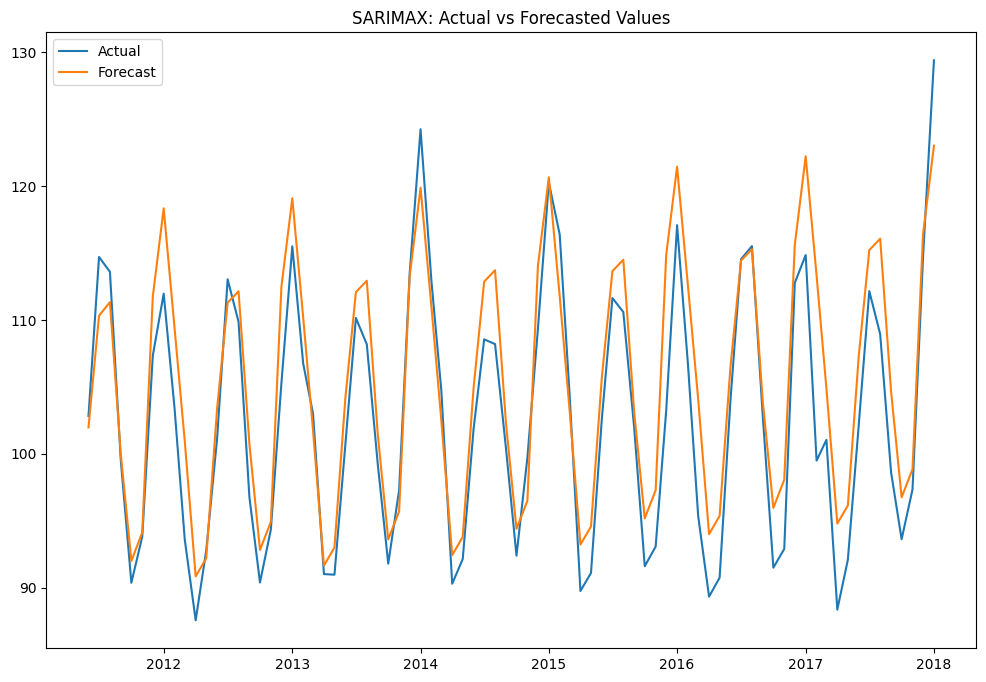

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(test.index, test['Value'], label='Actual')
plt.plot(test.index, test['forecast'], label='Forecast')
plt.legend()
plt.title("SARIMAX: Actual vs Forecasted Values")
plt.show()